# Creating a consumer resource model from smetana data
- load and parse the smetana data
- convert the data into a SBML model (with first order reactions)
- simulate the model using tellurium 
- convert into a mira model and simulate the model using pyciemss

### import packages and load data

In [46]:
import pandas as pd
import tellurium as te
import antimony as at
import simplesbml 
import mira
import libsbml
import numpy as np
from mira.sources.sbml import template_model_from_sbml_file
from mira.metamodel import Distribution

import os
import pyciemss
import torch

import pyciemss.visuals.plots as plots
import pyciemss.visuals.vega as vega
import pyciemss.visuals.trajectories as trajectories

from pyciemss.integration_utils.intervention_builder import (
    param_value_objective,
    start_time_objective,
    start_time_param_value_objective,
)


In [ ]:
smetana_file = "../data/smetana_results/smetana_results_gurobi_victor_detailed.tsv"
smetana_df = pd.read_csv(smetana_file, sep='\t')
smetana_df

### create antimony model using first order reaction kinetics 

for each row of the smetana data:

- donor-to-compound reaction: donor -> compound; rate: k_d*donor

- compound-to-receiver reaction: compound -> receiver; k_r*compound

- use uniform(0,1) initial values for the model variables (donor, compound, receiver)

- k_d = scs and k_r = mus for that row 

In [ ]:

seed = 0
np.random.seed(seed)

reaction_list = []
parameter_list = []
initial_values_set = set()


for index, row in smetana_df.iterrows():
    donor_reaction = f'\t{row.donor} -> {row.compound}; k_d{index}*{row.donor}'
    receiver_reaction = f'\t{row.compound} -> {row.receiver}; k_r{index}*{row.compound}'
    reaction_list.extend([donor_reaction,receiver_reaction])
    parameter_list.extend([f'\tk_d{index}={row.scs}',f'\tk_r{index}={row.mus}'])
    initial_values_set.add(row.donor)
    initial_values_set.add(row.compound)
    initial_values_set.add(row.receiver)

initial_values_string = "\n".join([f"\t{name}={np.random.uniform(0,1)}" for name in initial_values_set])
species_names_string = "\n".join([f'\t{species} is "{species}"' for species in initial_values_set])

reaction_string = "\n".join(reaction_list)
parameter_string = "\n".join(parameter_list)

antimony_file = f"""
model smetana
{reaction_string}
{parameter_string}
{initial_values_string}
{species_names_string}
end
"""

print(antimony_file)

### save antimony model as SBML using tellurium and libroadrunner

In [ ]:
smbl_file = 'smetana_carbstor_consumer_resource.xml'
rr_model = te.loada(antimony_file)
rr_model.exportToSBML(smbl_file)



### simulate SBML model

In [ ]:
# simulate and plot
rr_model.simulate(0, 500, 500)
rr_model.plot()

### Update SBML species name, initial concentration, and has_only_substance_units fields

the exported file from tellurium does not have the species names, concentrations, and has_only_substance_units correctly set to use with MIRA and PYCIEMSS 

TODO: fix this ^^

In [ ]:

corrected_smbl_file = 'smetana_carbstor_consumer_resource_corrected.xml'

d = libsbml.readSBMLFromFile(smbl_file)
m = d.getModel()
# for initial in m.getListOfInitialAssignments():
#     print(initial)

for species in m.getListOfSpecies():
    species.name = species.id
    species.initial_concentration = species.initial_amount
    species.has_only_substance_units = False

libsbml.writeSBMLToFile(d,corrected_smbl_file)

### load SBML into MIRA

see: https://github.com/gyorilab/mira/tree/main and https://miramodel.readthedocs.io/en/latest/

In [ ]:
smetana_model = template_model_from_sbml_file(corrected_smbl_file)

smetana_model.initials


### assign priors in mira model (optional)

compartment is considered a parameter in this model but it does not get a prior (for now)

In [ ]:
### for priors

# from mira.metamodel import Distribution


# dist = Distribution(
#                     type= "Uniform1",
#                     parameters= {"minimum": 0.0,"maximum": 1.0 }     
#                      )

# for name,parameter in smetana_model.parameters.items():
#     if name != "default_compartment":
#         parameter.distribution = dist

# parameter

### simulate the model in pyCIEMSS (specify initial conditions)

see: https://github.com/ciemss/pyciemss/blob/main/docs/source/interfaces.ipynb

first set the simulation parameters

In [ ]:
# set simulation and sampling parameters
start_time = 0.0
end_time = 500.0
logging_step_size = 1.0
num_samples = 1


In [ ]:
result1 = pyciemss.sample(smetana_model, end_time, logging_step_size, num_samples, start_time=start_time)
display(result1['data'].head())
print(result1.keys())

### plot results

these should be the same as the tellurium simulation (without using priors) 

In [ ]:
# Plot results for all states
schema = plots.trajectories(result1["data"], keep=".*_state")
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

# Model calibration

- simulate 4 datasets in tellurium using the same SBML model (i.e., reactions, parameters and initial conditions): 
  1. all observables, 6 time points, should reach steady state, no noise
  2. all observables, 12 time points, should reach steady state, no noise
  3. donor and receiver (no metabolites), 6 time points, should reach steady state, no noise
  4.  donor and receiver (no metabolites), 12 time points, should reach steady state, no noise
- for each of the 4 datasets calibrate the model using pyciemss
- evaluate the quality of calibration and information gained for 6 vs 12 time points, all observables vs no metabolites

### simulating data

In [35]:
smetana_carbstor_sbml_file = './smetana_carbstor_consumer_resource_corrected.xml'
rr_model = te.loadSBMLModel(smetana_carbstor_sbml_file)

all_species = rr_model.getFloatingSpeciesIds()
species_wo_metabolites = [s for s in all_species if not s.startswith('M')]

print(f'The model contains {len(species_wo_metabolites)} donor and receiver species and {len(all_species)-len(species_wo_metabolites)} metabolite compounds.')


The model contains 5 donor and receiver species and 27 metabolite compounds.


In [36]:
def create_custom_time_vector(num_points_initial, num_points_steady, t_initial_end=100, t_total_end=500):
    """Create a custom time vector with specified number of points"""
    initial_phase = np.linspace(0, t_initial_end, num_points_initial, endpoint=False)
    steady_phase = np.linspace(t_initial_end, t_total_end, num_points_steady)
    time_vector = np.concatenate((initial_phase, steady_phase))
    return time_vector


time_points_6 = create_custom_time_vector(3, 3, 50, 500)
time_points_12 = create_custom_time_vector(6, 6, 50, 500)

print(f"Time vector with 6 points: {time_points_6}")
print(f"Time vector with 12 points: {time_points_12}")

Time vector with 6 points: [  0.          16.66666667  33.33333333  50.         275.
 500.        ]
Time vector with 12 points: [  0.           8.33333333  16.66666667  25.          33.33333333
  41.66666667  50.         140.         230.         320.
 410.         500.        ]


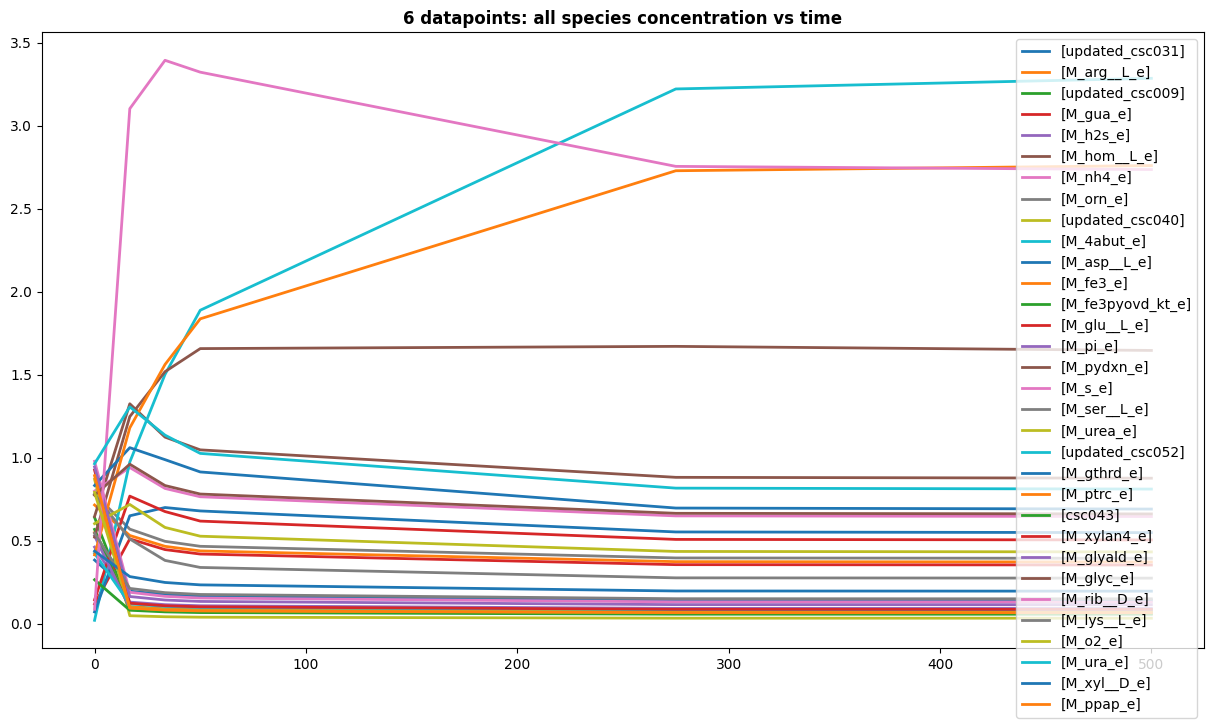

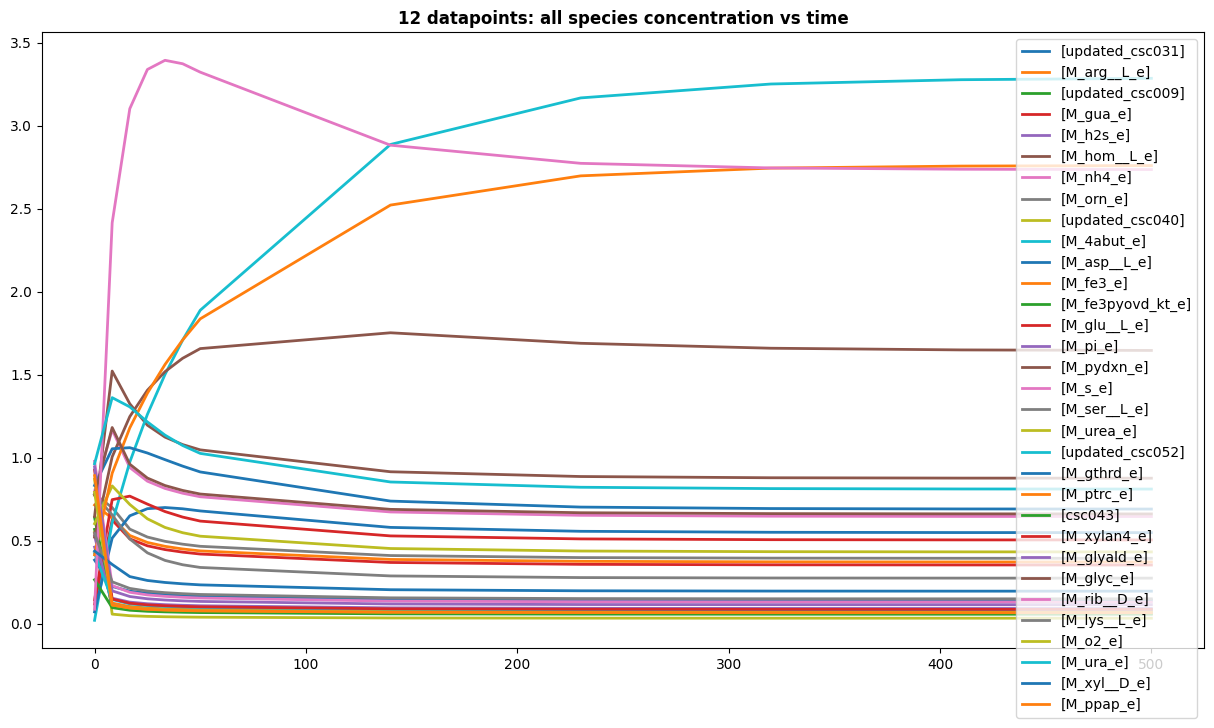

In [39]:

# simulate and plot
results1 = rr_model.simulate(times=time_points_6)
rr_model.plot(title='6 datapoints: all species concentration vs time', figsize=(15, 8))
rr_model.resetToOrigin()

results2 = rr_model.simulate(times=time_points_12)
rr_model.plot(title='12 datapoints: all species concentration vs time', figsize=(15, 8))
rr_model.resetToOrigin()

In [40]:

def format_and_save_road_runner_results(fname, rr_results, obs_mets=True):
    formatted_df = pd.DataFrame(rr_results, columns=rr_results.colnames)
    if not obs_mets:
        formatted_df = formatted_df.loc[:, ~formatted_df.columns.str.startswith('[M')]
    formatted_df = formatted_df.set_index('time')
    formatted_df.index.names = ['Timestamp']  # must be 'Timestamp' for pyciemss
    formatted_df.to_csv(fname)
    return formatted_df

In [42]:
# all observations (incl. metabolites), 6 time points
all_obs_6_measurements_data_file_path = 'simulated_data_w_mets_6_measurements.csv'
all_obs_6_measurements = format_and_save_road_runner_results(all_obs_6_measurements_data_file_path,results1, obs_mets=True )
all_obs_6_measurements.head()

,[updated_csc031],[M_arg__L_e],[updated_csc009],[M_gua_e],[M_h2s_e],[M_hom__L_e],[M_nh4_e],[M_orn_e],[updated_csc040],[M_4abut_e],...,[csc043],[M_xylan4_e],[M_glyald_e],[M_glyc_e],[M_rib__D_e],[M_lys__L_e],[M_o2_e],[M_ura_e],[M_xyl__D_e],[M_ppap_e]
Timestamp,,,,,,,,,,,,,,,,,,,,,
0.000000,0.383442,0.715189,0.639921,0.118274,0.461479,0.645894,0.799159,0.780529,0.870012,0.020218,...,0.264556,0.925597,0.944669,0.774234,0.087129,0.544883,0.791725,0.963663,0.437587,0.891773
16.666667,0.195565,0.531310,0.092628,0.510875,0.129911,1.325068,0.940969,0.569715,0.047904,0.973902,...,0.080912,0.123462,0.163623,0.960898,3.103334,0.212447,0.095270,1.306476,0.283691,0.093944
33.333333,0.176460,0.465988,0.081380,0.446400,0.114565,1.124149,0.814822,0.496172,0.041699,1.501985,...,0.071018,0.107870,0.142479,0.832387,3.394950,0.186863,0.083461,1.136138,0.248269,0.081787
50.000000,0.166966,0.438436,0.076730,0.419535,0.107902,1.047379,0.764771,0.466191,0.039066,1.888786,...,0.066841,0.101421,0.133944,0.781200,3.323508,0.175972,0.078636,1.026029,0.233785,0.076942
275.000000,0.141774,0.373697,0.066305,0.355622,0.092054,0.881812,0.649475,0.396047,0.033101,3.222327,...,0.057088,0.086500,0.114630,0.664992,2.755765,0.150355,0.067890,0.816732,0.196957,0.066310


In [43]:
# no metabolite observations, 6 time points
no_mets_6_measurements_data_file_path = 'simulated_data_no_mets_6_measurements.csv'
no_mets_6_measurements = format_and_save_road_runner_results(no_mets_6_measurements_data_file_path, results1, obs_mets=False)
no_mets_6_measurements.head()


,[updated_csc031],[updated_csc009],[updated_csc040],[updated_csc052],[csc043]
Timestamp,,,,,
0.000000,0.383442,0.639921,0.870012,0.423655,0.264556
16.666667,0.195565,0.092628,0.047904,0.119475,0.080912
33.333333,0.176460,0.081380,0.041699,0.104127,0.071018
50.000000,0.166966,0.076730,0.039066,0.097857,0.066841
275.000000,0.141774,0.066305,0.033101,0.083332,0.057088


In [44]:
# all observations (incl. metabolites), 12 time points
all_obs_12_measurements_data_file_path = 'simulated_data_w_mets_12_measurements.csv'
all_obs_12_measurements = format_and_save_road_runner_results(all_obs_12_measurements_data_file_path, results2, obs_mets=True)
all_obs_12_measurements.head()

,[updated_csc031],[M_arg__L_e],[updated_csc009],[M_gua_e],[M_h2s_e],[M_hom__L_e],[M_nh4_e],[M_orn_e],[updated_csc040],[M_4abut_e],...,[csc043],[M_xylan4_e],[M_glyald_e],[M_glyc_e],[M_rib__D_e],[M_lys__L_e],[M_o2_e],[M_ura_e],[M_xyl__D_e],[M_ppap_e]
Timestamp,,,,,,,,,,,,,,,,,,,,,
0.000000,0.383442,0.715189,0.639921,0.118274,0.461479,0.645894,0.799159,0.780529,0.870012,0.020218,...,0.264556,0.925597,0.944669,0.774234,0.087129,0.544883,0.791725,0.963663,0.437587,0.891773
8.333333,0.224400,0.636357,0.108520,0.624801,0.153491,1.522185,1.167701,0.699513,0.057381,0.608807,...,0.096399,0.148752,0.197690,1.182138,2.415646,0.252206,0.112226,1.362037,0.356922,0.112293
16.666667,0.195565,0.531310,0.092628,0.510875,0.129911,1.325068,0.940969,0.569715,0.047904,0.973902,...,0.080912,0.123462,0.163623,0.960898,3.103334,0.212447,0.095270,1.306476,0.283691,0.093944
25.000000,0.183689,0.489430,0.085459,0.469196,0.120146,1.195904,0.858641,0.522010,0.043947,1.261249,...,0.074582,0.113432,0.149978,0.877413,3.339722,0.196105,0.087723,1.215766,0.260271,0.086127
33.333333,0.176460,0.465988,0.081380,0.446400,0.114565,1.124149,0.814822,0.496172,0.041699,1.501985,...,0.071018,0.107870,0.142479,0.832387,3.394950,0.186863,0.083461,1.136138,0.248269,0.081787


In [45]:
# no metabolite observations, 12 time points
no_mets_12_measurements_data_file_path = 'simulated_data_no_mets_12_measurements.csv'
no_mets_12_measurements = format_and_save_road_runner_results(no_mets_12_measurements_data_file_path, results2, obs_mets=False)
no_mets_12_measurements.head()

,[updated_csc031],[updated_csc009],[updated_csc040],[updated_csc052],[csc043]
Timestamp,,,,,
0.000000,0.383442,0.639921,0.870012,0.423655,0.264556
8.333333,0.224400,0.108520,0.057381,0.145357,0.096399
16.666667,0.195565,0.092628,0.047904,0.119475,0.080912
25.000000,0.183689,0.085459,0.043947,0.109549,0.074582
33.333333,0.176460,0.081380,0.041699,0.104127,0.071018


### calibration

- assign priors (if needed)
- save as AMRPetriNet (JSON) file
- run calibration

In [48]:
smetana_carbstor_mira_model = template_model_from_sbml_file(smetana_carbstor_sbml_file)

## for priors use uniform(0,1)

from mira.metamodel import Distribution


dist = Distribution(
                    type= "Uniform1",
                    parameters= {"minimum": 0.0,"maximum": 1.0 }     
                     )

for name,parameter in smetana_carbstor_mira_model.parameters.items():
    if name != "default_compartment":
        parameter.distribution = dist

parameter

Parameter(name='default_compartment', display_name=None, description='', identifiers={}, context={}, units=None, value=1.0, distribution=None)

In [50]:
from mira.modeling.amr.petrinet import AMRPetriNetModel
from mira.modeling import Model

model_json_file_name = 'smetana_carbstor_mira_model_w_priors.json'
 
pm = AMRPetriNetModel(Model(smetana_carbstor_mira_model))
pm.to_json_file(
            model_json_file_name,
            name='smetana_carbstor_mira_model_w_priors',
            description="smetana_carbstor_mira_model_w_priors",
            indent=2,
        )



In [51]:
num_iterations = 10
data_mapping = {k:k.strip("[]") for k in all_obs_12_measurements.columns}  # remove '[]' for concentration added by Tellurium
model_path_or_json = model_json_file_name
data_path = all_obs_12_measurements_data_file_path
calibration_results = pyciemss.calibrate(model_path_or_json, data_path, data_mapping=data_mapping, num_iterations=num_iterations, verbose=True)

/Users/geor228/Github/pyciemss/pyciemss/integration_utils/observation.py:49: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



Data printout: This dataset contains 11 rows of data. The first column, Timestamp, begins at 0.0 and ends at 500.0. The subsequent columns are named: [updated_csc031], [M_arg__L_e], [updated_csc009], [M_gua_e], [M_h2s_e], [M_hom__L_e], [M_nh4_e], [M_orn_e], [updated_csc040], [M_4abut_e], [M_asp__L_e], [M_fe3_e], [M_fe3pyovd_kt_e], [M_glu__L_e], [M_pi_e], [M_pydxn_e], [M_s_e], [M_ser__L_e], [M_urea_e], [updated_csc052], [M_gthrd_e], [M_ptrc_e], [csc043], [M_xylan4_e], [M_glyald_e], [M_glyc_e], [M_rib__D_e], [M_lys__L_e], [M_o2_e], [M_ura_e], [M_xyl__D_e], [M_ppap_e]
iteration 0: loss = 34092.39667534828


In [52]:
calibration_results

{'inferred_parameters': AutoGuideList(
   (0): AutoDelta()
   (1): AutoLowRankMultivariateNormal()
 ),
 'loss': 16884.635594010353}

In [53]:
parameter_estimates = calibration_results["inferred_parameters"]
parameter_estimates()

{'persistent_k_d0': tensor(0.6270, grad_fn=<ExpandBackward0>),
 'persistent_k_r0': tensor(0.5562, grad_fn=<ExpandBackward0>),
 'persistent_k_d1': tensor(0.5706, grad_fn=<ExpandBackward0>),
 'persistent_k_r1': tensor(0.6148, grad_fn=<ExpandBackward0>),
 'persistent_k_d2': tensor(0.5620, grad_fn=<ExpandBackward0>),
 'persistent_k_r2': tensor(0.4417, grad_fn=<ExpandBackward0>),
 'persistent_k_d3': tensor(0.6020, grad_fn=<ExpandBackward0>),
 'persistent_k_r3': tensor(0.4180, grad_fn=<ExpandBackward0>),
 'persistent_k_d4': tensor(0.4297, grad_fn=<ExpandBackward0>),
 'persistent_k_r4': tensor(0.4389, grad_fn=<ExpandBackward0>),
 'persistent_k_d5': tensor(0.6577, grad_fn=<ExpandBackward0>),
 'persistent_k_r5': tensor(0.6096, grad_fn=<ExpandBackward0>),
 'persistent_k_d6': tensor(0.3257, grad_fn=<ExpandBackward0>),
 'persistent_k_r6': tensor(0.4541, grad_fn=<ExpandBackward0>),
 'persistent_k_d7': tensor(0.5157, grad_fn=<ExpandBackward0>),
 'persistent_k_r7': tensor(0.3221, grad_fn=<ExpandBackw

In [54]:
# set simulation and sampling parameters
start_time = 0.0
end_time = 500.0
logging_step_size = 10	#1.0
num_samples = 100

calibrated_sample_results = pyciemss.sample(smetana_carbstor_mira_model, end_time, logging_step_size, num_samples, 
                start_time=start_time, inferred_parameters=parameter_estimates)
display(calibrated_sample_results["data"].head())


,timepoint_id,sample_id,timepoint_unknown,persistent_k_d0_param,persistent_k_r0_param,persistent_k_d1_param,persistent_k_r1_param,persistent_k_d2_param,persistent_k_r2_param,persistent_k_d3_param,...,csc043_state,M_xylan4_e_state,M_glyald_e_state,M_glyc_e_state,M_rib__D_e_state,M_lys__L_e_state,M_o2_e_state,M_ura_e_state,M_xyl__D_e_state,M_ppap_e_state
0,0,0,0.0,0.651553,0.516574,0.602574,0.631426,0.625773,0.505862,0.562251,...,0.264556,0.925597,0.944669,0.774234,0.087129,0.544883,0.791725,0.963663,0.437587,0.891773
1,1,0,10.0,0.651553,0.516574,0.602574,0.631426,0.625773,0.505862,0.562251,...,0.479271,0.438474,0.540167,0.637923,0.999419,0.782377,0.813625,0.514155,0.370046,0.384515
2,2,0,20.0,0.651553,0.516574,0.602574,0.631426,0.625773,0.505862,0.562251,...,0.479252,0.438455,0.540267,0.637903,0.999678,0.782447,0.813958,0.501208,0.370164,0.383916
3,3,0,30.0,0.651553,0.516574,0.602574,0.631426,0.625773,0.505862,0.562251,...,0.479237,0.438441,0.540255,0.637884,0.999652,0.782427,0.813945,0.500820,0.370150,0.383909
4,4,0,40.0,0.651553,0.516574,0.602574,0.631426,0.625773,0.505862,0.562251,...,0.479236,0.438439,0.540253,0.637882,0.999648,0.782424,0.813943,0.500806,0.370148,0.383908


In [55]:
calibrated_sample_results.keys()
calibrated_sample_results['unprocessed_result'].keys()

dict_keys(['persistent_k_d0', 'persistent_k_r0', 'persistent_k_d1', 'persistent_k_r1', 'persistent_k_d2', 'persistent_k_r2', 'persistent_k_d3', 'persistent_k_r3', 'persistent_k_d4', 'persistent_k_r4', 'persistent_k_d5', 'persistent_k_r5', 'persistent_k_d6', 'persistent_k_r6', 'persistent_k_d7', 'persistent_k_r7', 'persistent_k_d8', 'persistent_k_r8', 'persistent_k_d9', 'persistent_k_r9', 'persistent_k_d10', 'persistent_k_r10', 'persistent_k_d11', 'persistent_k_r11', 'persistent_k_d12', 'persistent_k_r12', 'persistent_k_d13', 'persistent_k_r13', 'persistent_k_d14', 'persistent_k_r14', 'persistent_k_d15', 'persistent_k_r15', 'persistent_k_d16', 'persistent_k_r16', 'persistent_k_d17', 'persistent_k_r17', 'persistent_k_d18', 'persistent_k_r18', 'persistent_k_d19', 'persistent_k_r19', 'persistent_k_d20', 'persistent_k_r20', 'persistent_k_d21', 'persistent_k_r21', 'persistent_k_d22', 'persistent_k_r22', 'persistent_k_d23', 'persistent_k_r23', 'persistent_k_d24', 'persistent_k_r24', 'persiste

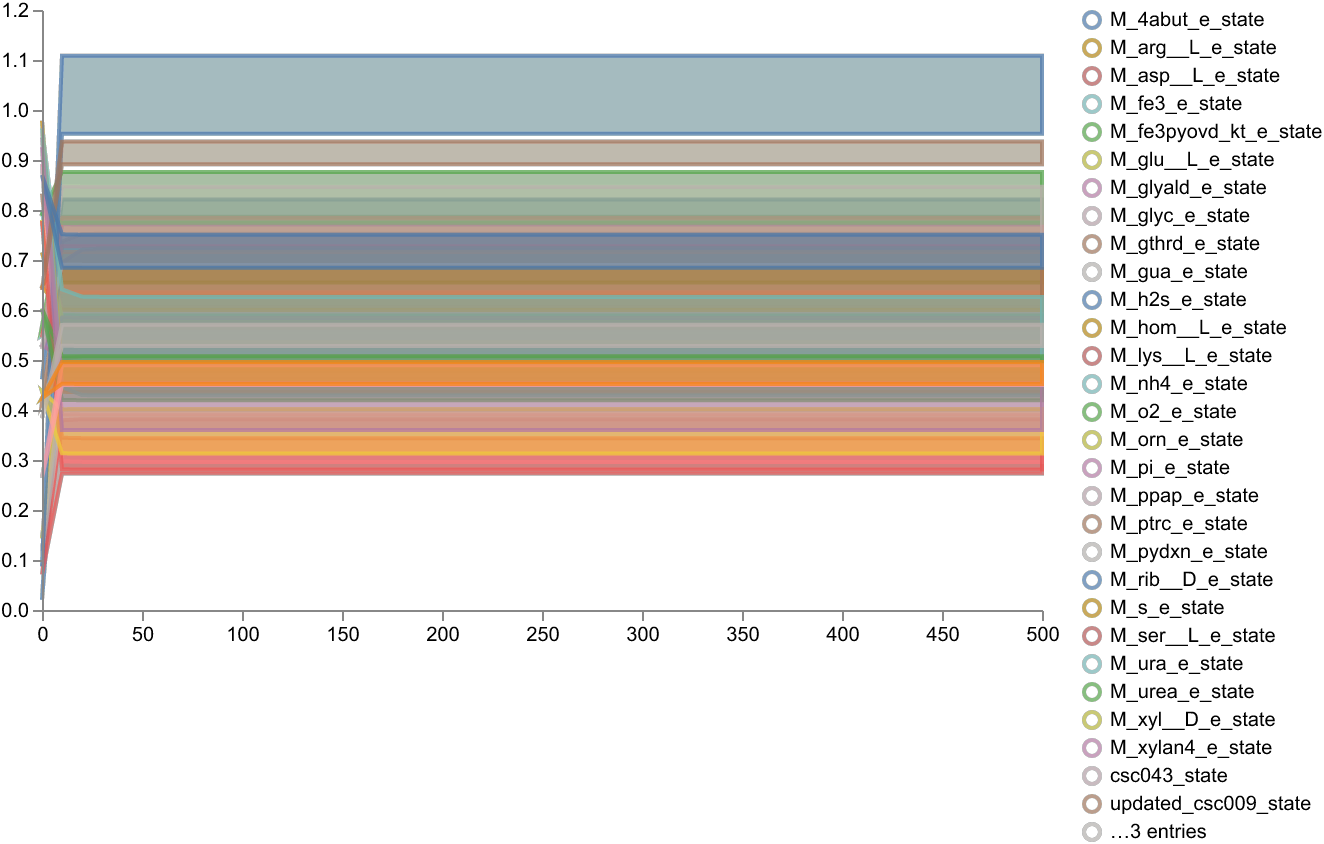

In [56]:
# Plot results for all states
schema = plots.trajectories(calibrated_sample_results["data"], keep=".*_state")
#plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

In [ ]:
# evaluate calibration results